In [66]:
%reload_ext autoreload
%autoreload 2

In [67]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [68]:
from ripple_heterogeneity.readout import readout_explained_var

df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
cell_metrics = loading.load_all_cell_metrics(df.basepath)

sessions = pd.DataFrame()
sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")
].basepath.unique()

In [85]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid"
)

batch_analysis.run(
    sessions,
    save_path,
    readout_explained_var.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)

 46%|████▌     | 48/105 [00:24<00:09,  5.75it/s]

In [70]:
pairwise_corr_df["corrcoef"] = pairwise_corr_df["corr"] 
pairwise_corr_df = pairwise_corr_df.drop(["corr"], axis=1)


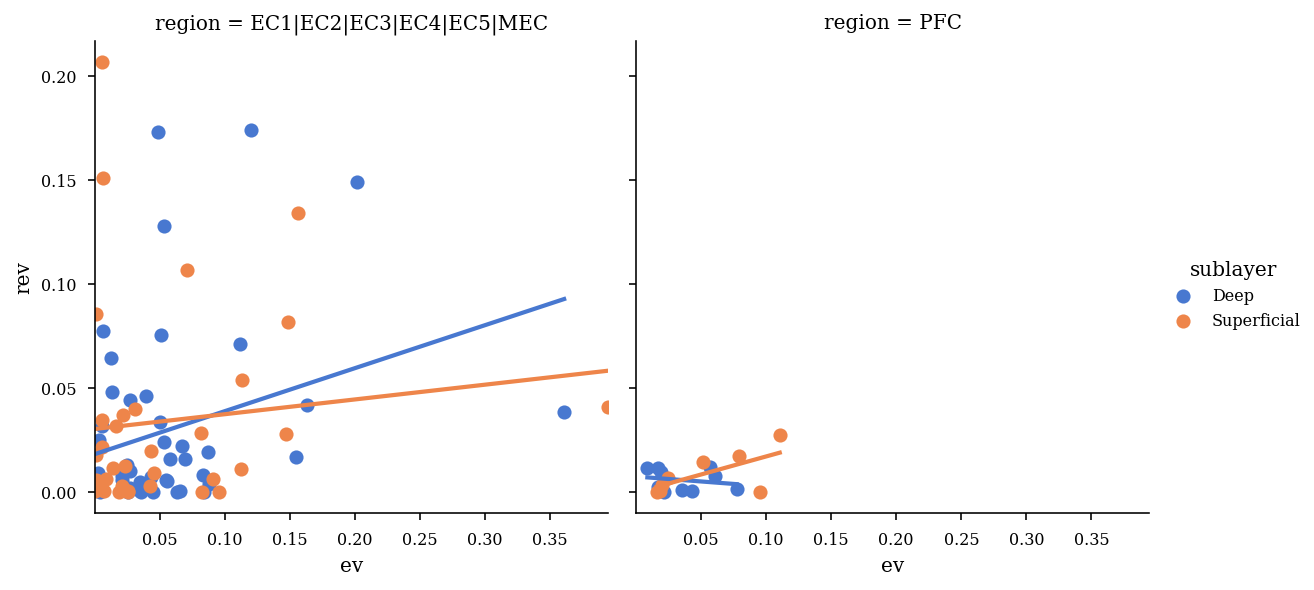

In [71]:
sns.lmplot(x="ev", y="rev", col="region", hue="sublayer", data=ev_df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

In [72]:
ev_df

,region,sublayer,ev,rev,n_ca1,n_target,basepath
0,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.004728,0.002505,17.0,10.0,Z:\Data\AYAold\AYA7\day19
1,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.002046,0.005328,5.0,10.0,Z:\Data\AYAold\AYA7\day19
2,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.049873,0.033667,24.0,44.0,Z:\Data\AYAold\AYA7\day20
3,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.084256,0.000006,38.0,68.0,Z:\Data\AYAold\AYA7\day24
4,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.006213,0.150868,12.0,68.0,Z:\Data\AYAold\AYA7\day24
...,...,...,...,...,...,...,...
96,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.043279,0.006997,25.0,11.0,Z:\Data\Kenji\ec016.577_590
97,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.081617,0.028408,52.0,11.0,Z:\Data\Kenji\ec016.577_590
98,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.082086,0.000026,15.0,14.0,Z:\Data\Kenji\i01_maze01_MS.001_003
99,PFC,Deep,0.077278,0.001288,25.0,15.0,Z:\Data\ORproject\OR18\day1


In [73]:
df_long = pd.DataFrame()
df_long["ev"] = np.hstack([ev_df.ev.values, ev_df.rev.values])
df_long["ev_labels"] = np.hstack([["ev"]*ev_df.ev.shape[0], ["rev"]*ev_df.rev.shape[0]])
df_long["region"] = np.hstack([ev_df.region.values, ev_df.region.values])
df_long["sublayer"] = np.hstack([ev_df.sublayer.values, ev_df.sublayer.values])
df_long["n_ca1"] = np.hstack([ev_df.n_ca1.values, ev_df.n_ca1.values])
df_long["n_target"] = np.hstack([ev_df.n_target.values, ev_df.n_target.values])
df_long["basepath"] = np.hstack([ev_df.basepath.values, ev_df.basepath.values])


df_long

,ev,ev_labels,region,sublayer,n_ca1,n_target,basepath
0,0.004728,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,17.0,10.0,Z:\Data\AYAold\AYA7\day19
1,0.002046,ev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,5.0,10.0,Z:\Data\AYAold\AYA7\day19
2,0.049873,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,24.0,44.0,Z:\Data\AYAold\AYA7\day20
3,0.084256,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,38.0,68.0,Z:\Data\AYAold\AYA7\day24
4,0.006213,ev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,12.0,68.0,Z:\Data\AYAold\AYA7\day24
...,...,...,...,...,...,...,...
197,0.006997,rev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,25.0,11.0,Z:\Data\Kenji\ec016.577_590
198,0.028408,rev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,52.0,11.0,Z:\Data\Kenji\ec016.577_590
199,0.000026,rev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,15.0,14.0,Z:\Data\Kenji\i01_maze01_MS.001_003
200,0.001288,rev,PFC,Deep,25.0,15.0,Z:\Data\ORproject\OR18\day1


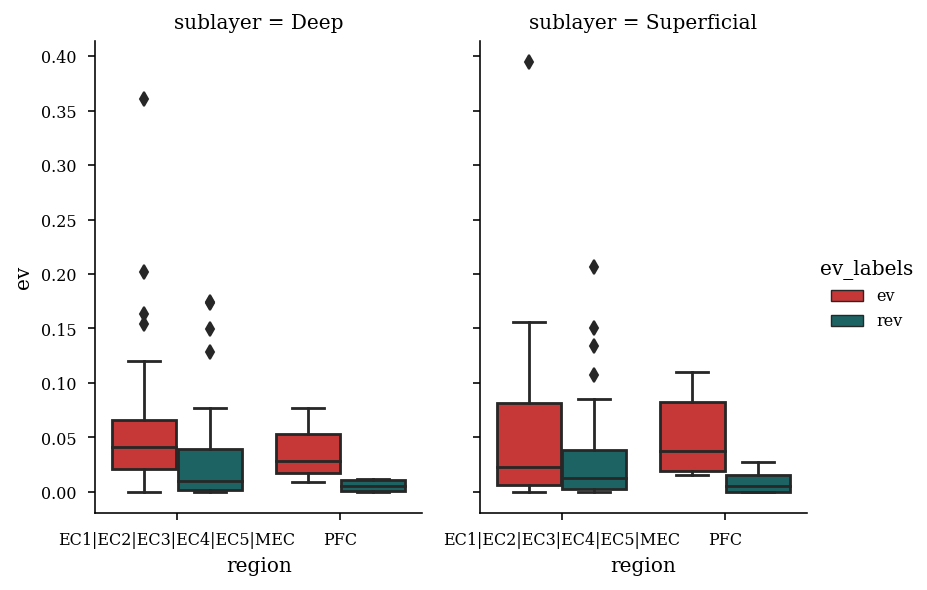

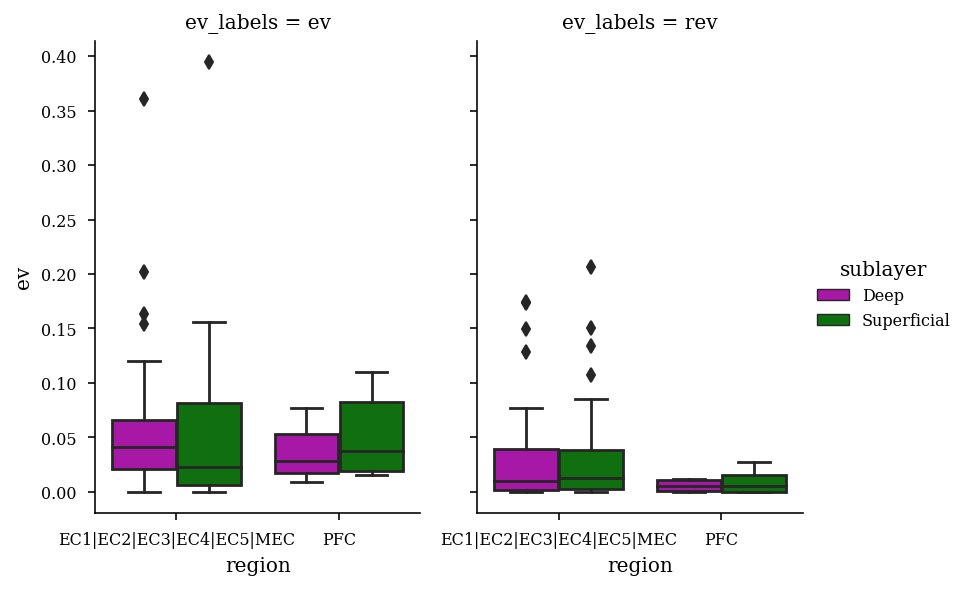

In [74]:
g = sns.catplot(x="region", y="ev",
                hue="ev_labels", col="sublayer",
                data=df_long, kind="box",
                height=4, aspect=.7)
sns.despine()
plt.show()

g = sns.catplot(x="region", y="ev",
                hue="sublayer", col="ev_labels",
                data=df_long, kind="box",palette=["m", "g"],
                height=4, aspect=.7)

# g = sns.catplot(x="region", y="ev",
#                 hue="sublayer", col="ev_labels",
#                 data=df_long,palette=["m", "g"],
#                 height=4, aspect=.7)
sns.despine()
plt.show()

In [75]:
ev_df.basepath.value_counts(), ev_df.region.value_counts() 

ev_df["ev_norm"] = ev_df.ev - ev_df.rev

In [76]:
df_wide = pd.pivot(
    ev_df, index=["region","basepath"], columns="sublayer", values=["ev","rev"]
).reset_index()
df_wide
df_wide["deep_ev_norm"] = df_wide["ev"]["Deep"] - df_wide["rev"]["Deep"]
df_wide["sup_ev_norm"] = df_wide["ev"]["Superficial"] - df_wide["rev"]["Superficial"]
df_wide
# ratio between deep and sup normed ev (offset by 1 for ratio)
df_wide["deep_sup_ev_ratio_ev_norm"] = ((df_wide["deep_ev_norm"]+1) - (df_wide["sup_ev_norm"]+1)) / ((df_wide["deep_ev_norm"]+1) + (df_wide["sup_ev_norm"]+1))

df_wide["deep_sup_ev_ratio"] = (df_wide["ev"]["Deep"] - df_wide["ev"]["Superficial"]) / (df_wide["ev"]["Deep"] + df_wide["ev"]["Superficial"])

df_wide["constant"] = 1
df_wide.head(10)

region                   basepath        ev  \
sublayer                                                          Deep   
0         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day19  0.004728   
1         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day20  0.049873   
2         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day24  0.084256   
3         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day12  0.002165   
4         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day14  0.000195   
5         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day15  0.044488   
6         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day16  0.021178   
7         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day17  0.038460   
8         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day10  0.035043   
9         EC1|EC2|EC3|EC4|EC5|MEC          Z:\Data\HMC1\day8  0.035176   

                           rev             deep_ev_norm sup_ev_norm  \
sublayer Superficial      Deep Superficial                            
0           0.002046  0.002505    0.005328     0.002223   -0.003282   
1                NaN  0.033667         NaN     0.016206         NaN   
2           0.006213  0.000006    0.150868     0.084250   -0.144655   
3           0.005612  0.009279    0.034756    -0.007114   -0.029143   
4           0.000628  0.000695    0.005523    -0.000500   -0.004895   
5           0.022853  0.000006    0.000883     0.044482    0.021970   
6           0.030560  0.005944    0.039689     0.015234   -0.009130   
7           0.021589  0.001969    0.037223     0.036491   -0.015635   
8           0.045811  0.000227    0.009063     0.034816    0.036748   
9           0.043187  0.000077    0.019637     0.035099    0.023550   

         deep_sup_ev_ratio_ev_norm deep_sup_ev_ratio constant  
sublayer                                                       
0                         0.002754          0.395880        1  
1                              NaN               NaN        1  
2                         0.118017          0.862647        1  
3                         0.011218         -0.443321        1  
4                         0.002203         -0.526842        1  
5                         0.010894          0.321282        1  
6                         0.012145         -0.181338        1  
7                         0.025794          0.280957        1  
8                        -0.000933         -0.133177        1  
9                         0.005610         -0.102234        1

In [77]:
from scipy import stats
x = df_wide[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC"].deep_sup_ev_ratio_ev_norm
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "PFC"].deep_sup_ev_ratio_ev_norm
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC"].deep_sup_ev_ratio
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "PFC"].deep_sup_ev_ratio
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

Ttest_1sampResult(statistic=2.5152086506574496, pvalue=0.017113825441010724)
Ttest_1sampResult(statistic=-1.568025625478165, pvalue=0.16086179893507047)
Ttest_1sampResult(statistic=1.99271403621524, pvalue=0.05487979433711714)
Ttest_1sampResult(statistic=-1.5559842183041561, pvalue=0.1636652430816687)


In [78]:
import statsmodels.formula.api as smf
results = smf.ols('deep_sup_ev_ratio_ev_norm ~ region', data=df_wide).fit()
print(results.summary())



                                OLS Regression Results                               
Dep. Variable:     deep_sup_ev_ratio_ev_norm   R-squared:                       0.100
Model:                                   OLS   Adj. R-squared:                  0.077
Method:                        Least Squares   F-statistic:                     4.315
Date:                       Sat, 04 Jun 2022   Prob (F-statistic):             0.0444
Time:                               12:39:53   Log-Likelihood:                 91.920
No. Observations:                         41   AIC:                            -179.8
Df Residuals:                             39   BIC:                            -176.4
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [79]:
results = smf.ols('deep_sup_ev_ratio ~ region', data=df_wide).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      deep_sup_ev_ratio   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.373
Date:                Sat, 04 Jun 2022   Prob (F-statistic):             0.0431
Time:                        12:40:01   Log-Likelihood:                -21.276
No. Observations:                  41   AIC:                             46.55
Df Residuals:                      39   BIC:                             49.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1490      0.073      2.053

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EC1|EC2|EC3|EC4|EC5|MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=4.441e-02 stat=2.077e+00


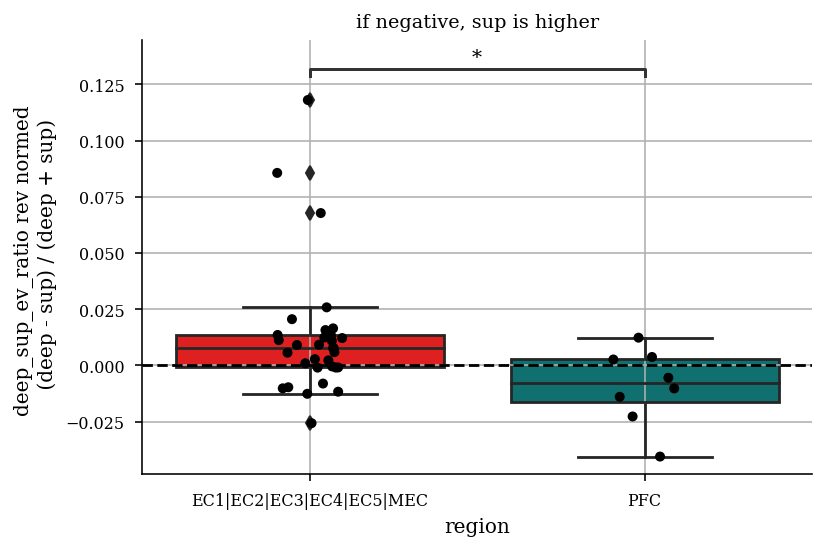

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EC1|EC2|EC3|EC4|EC5|MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=4.306e-02 stat=2.091e+00


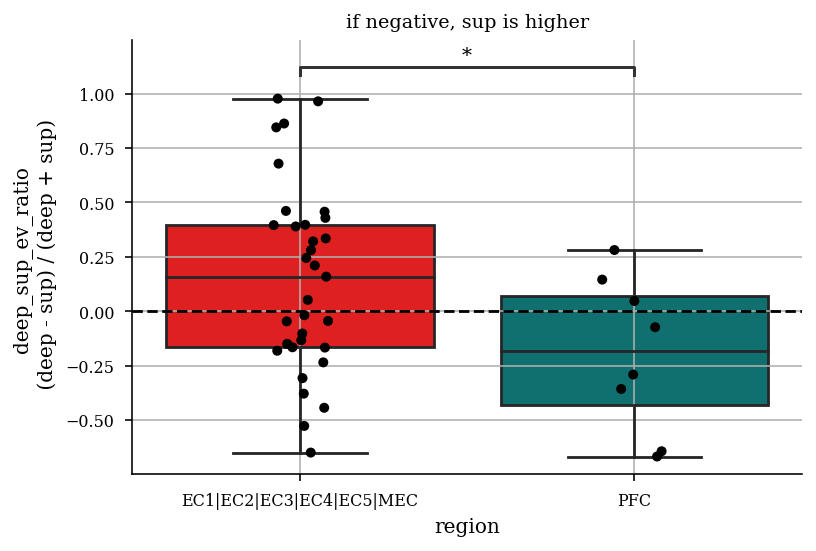

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=6.822e-01 stat=-9.812e-01
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=3.875e-01


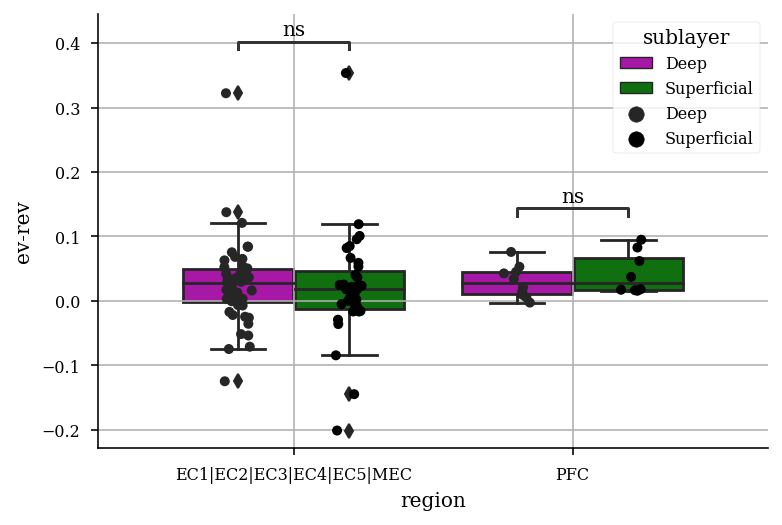

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=5.638e-01 stat=-1.114e+00
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.344e-01


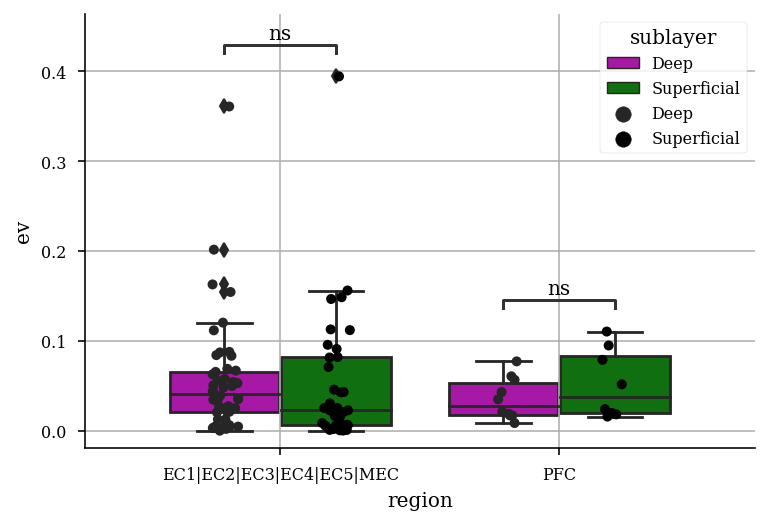

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=8.520e-01 stat=-8.169e-01
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-4.241e-01


(<AxesSubplot:xlabel='region', ylabel='rev'>,
  <statannot.StatResult.StatResult at 0x213e9300400>])

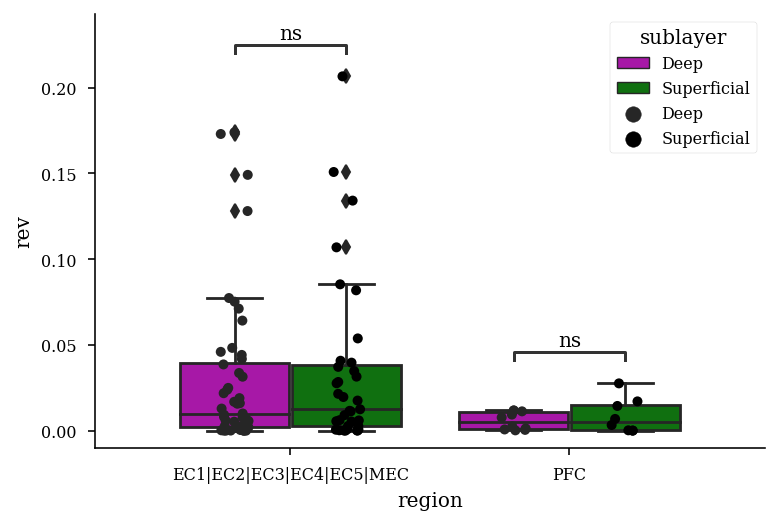

In [80]:
from statannot import add_stat_annotation

sns.boxplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            palette=["r", "teal"],
            data=df_wide)
sns.stripplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            data=df_wide,dodge=True,color='k')
sns.despine()
plt.ylabel("deep_sup_ev_ratio rev normed \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='k', linestyle='--')
plt.grid()
plt.title("if negative, sup is higher")
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio_ev_norm", x="region",order=["EC1|EC2|EC3|EC4|EC5|MEC", "PFC"],
                    box_pairs=[("EC1|EC2|EC3|EC4|EC5|MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="deep_sup_ev_ratio", x="region",
            palette=["r", "teal"],
            data=df_wide)
sns.stripplot(y="deep_sup_ev_ratio", x="region",color='k',
            data=df_wide,dodge=True)
sns.despine()
plt.ylabel("deep_sup_ev_ratio \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='k', linestyle='--')
plt.grid()
plt.title("if negative, sup is higher")
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio", x="region",order=["EC1|EC2|EC3|EC4|EC5|MEC", "PFC"],
                    box_pairs=[("EC1|EC2|EC3|EC4|EC5|MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()


sns.boxplot(y="ev_norm", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)
sns.stripplot(y="ev_norm", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
plt.ylabel('ev-rev')
plt.grid()
box_pairs=[(("EC1|EC2|EC3|EC4|EC5|MEC", "Deep"), ("EC1|EC2|EC3|EC4|EC5|MEC", "Superficial")),
                (("PFC", "Deep"), ("PFC", "Superficial")),
            ]
add_stat_annotation(plt.gca(), data=ev_df, y="ev_norm", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="ev", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)

sns.stripplot(y="ev", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
plt.grid()
add_stat_annotation(plt.gca(), data=ev_df, y="ev", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="rev", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)
sns.stripplot(y="rev", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
add_stat_annotation(plt.gca(), data=ev_df, y="rev", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=4.441e-02 stat=2.077e+00


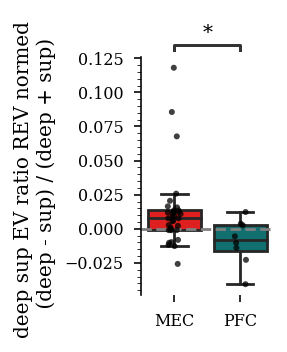

In [84]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"MEC": "#de2020", "PFC": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))

df_wide.loc[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"

ax = sns.boxplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            palette=["#de2020", "#116f70"],
            data=df_wide,showfliers=False,saturation=1)
sns.stripplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            data=df_wide,dodge=True,color='k',size=3,alpha=.75)


sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("deep sup EV ratio REV normed \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='grey', linestyle='--')
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio_ev_norm", x="region",order=["MEC", "PFC"],
                    box_pairs=[("MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "explained_var_deep_sup_ratio_regions.svg"),
    dpi=300,
    bbox_inches="tight",
)